In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

We will use FashionMNIST!

# 0. Basic Stuff / setting up

## 0.0 package import하고, device등등 setting하기

In [2]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
#import torchtext
from torch.utils.data import Dataset, DataLoader

In [3]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


## 0.1. Utils 
* `train`, `evaluate`를 정의하자
* `plot_history`, `plot_data`

In [4]:
def train(model, train_loader, optimizer, scheduler = None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = enumerate(tqdm(train_loader, desc =  "Epoch {}".format(epoch)))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
    if scheduler is not None:
        scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

In [5]:
def plot_history(history):
    plt.figure(figsize=(3 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['test_loss'], label="test_loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(history['train_acc'], label="train_acc")
    plt.plot(history['test_acc'], label="test_acc")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

In [6]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            image = image.squeeze(axis=0)
            ax[i][j].imshow(image, cmap=plt.get_cmap('gray'))
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

## 0.2. Loading the Fashion MNIST 

In [7]:
#하다보니 안되서 /data저장된 것을 지우고 다시 깔았다 

In [8]:
import torch
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=True, download=True,
                          transform=transforms.Compose([transforms.ToTensor(),
                                                        transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=False, transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                          ])),
                          batch_size=BATCH_SIZE, shuffle=True)

overfitting이 되는 것을 돌려서 보고, 이것을 해결하기위해 regularization되는 것을 보자

# 1. Regularization
There are many ways to do regularization (avoiding overfitting) (L1, L2 loss만 있는 것이 아님)

<br> 


> Regularization 종류들이 다양함 (train loss가 test loss보다 크지 않도록 regularize하는 아이들 모두다)L1, L2만 regularization인것이 아니다!)
#### **types of regularization techniques**

1. hidden layer forward pass modification
    * Dropout : `nn.Dropout` 
    * Batch Normalization : `nn.BatchNorm2d`
2. training step modification
    * early stopping : training step에서 한다
3. optimizer/loss funciton modification
    * L1, L2 regularization 
    
        **two ways to implement this**
        * `optimizer`에서 `weight_decay` option 넣어주기
        * loss자체에서 L1, L2 regularization term을 넣어서 정의해주기 (less often used)
4. input data modification
    * random data augmentation (중간에 구멍 뚫기, flip image and so on)



1. doing to hidden layer forward pass
    * Dropout : `nn.Dropout` 
    * Batch Normalization : `nn.BatchNorm2d`
2. doing to during training
    * early stopping 
3. add to optimizer/loss function
   * L1, L2 regularization (밑에 적음)
       * `optimizer`에 weight decay하거나
       * loss 자체에서 regularization term을 넣거나
4. Data augmentation? (중간에 구멍 뚫기, flip image and so on)

<br><br>
L1, L2 Regularization 한느 방법
1. 코드에서 optimizer에서 weight decay를 썼다 (weight decay : L1, L2 regularization하는 것)
    * weight_decay라고 불리는 이유 : weight를 감소하는 효과를 지니게 되니 (regularization)을 하면
2. loss함수 자체에서 regularization term을 정의해줘서 넣는 것 

<br>
weight decay와 L2 loss 는 조금씩 다르다

> 많은 책과 자료에서 L2 regularization 과 weight decay는 서로 같은 것이라고 말한다. 그럼 과연 L2 regularization과 weight decay는 정말 같은 것일까? 정답은 일부는 맞고 일부는 틀리다. SGD에 대해서는 맞지만 Adam에 대해서는 틀리다. Adam을 포함한 adaptive learning rate를 사용하는 optimizer들은 SGD와 다른 weight 업데이트 식을 사용하기 때문이다. 

https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html

<br><br>
weight decay pytorch에 대한 설명 : https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105/10



(이거랑 regularization이랑 다른가..?) =>했갈림
(또는, loss function에서 lambda를 추가할 수 있다?? (제대로 이해해야할듯)

## 1.1. Dropout 
we can use `nn.Dropout` (predefined module)


(즉, 밑에서 custom하게 dropout을 정의하기는 했는데 원래는 이미 정의가 되어있다)

In [9]:
#dropout 을 imoprt해서 써도 되지만 실제로 만들어보자
#cusotm Dropout thing
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout,self).__init__()
        p = 1-p  # p값이 크면 dropout많이 되도록
        if p<0 or p>1:
            raise ValueError("p value should be between 0 and 1")
        self.p = p
        
    def forward(self, input_tensor): #input : tensor
        #강의와 달리, torch를 써서 masking을 했다 (gpu 에서 더 빠르게 하기 위해서)
        mask = (torch.rand(input_tensor.shape, device = DEVICE)< self.p)/self.p #나누는 이유는 배웠었다 (값이 줄어드니)
        output = input_tensor*mask #element wise multiplication
        return output #output.to(DEVICE)를 해야할 수도 있으나, 여기서는 애초에 gpu에서 시작했기 때문에 상관 없음

In [10]:
#testing it out
x = torch.rand((3,2), device = DEVICE)
Dropout(p=0.1)(x)

/Users/eunmi/opt/anaconda3/envs/ML_tutor/lib/python3.8/site-packages/torch/_tensor_str.py:107: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0)


tensor([[0.2095, 0.7410],
        [1.0115, 0.5023],
        [0.5445, 0.7688]], device='mps:0')

**참고로, 밑의 코드와 강의 코드와 다른 점:**
1. F.log_softmax를 없앴다 (softmax를 모델내에서 한번 했는데, cross entropy loss거칠떄 softmax를 한번 더해주게 되어서, 그러면 안되서)
2. p 를 input으로 받게 함 (즉, dropoutrate를 model만들때 넣어주도록 만들었따)

In [11]:
#p : dropout 정도로 하는 것을 input으로 받음 (lab코드랑 다른 점)
class RegClassifier_with_dropout(nn.Module):
    def __init__(self,p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = Dropout(p) #define using the predefined dropout we used
    
    def forward(self, x):
        x = x.view(x.shape[0],-1)  #original
        #x = torch.flatten(x) # THIS FLATTENIKNG DOES NOT WORK
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        #x = F.log_softmax(self.fc4(x), dim = 1) 
        #log_softmax는, 뒤에 CrossEntropyLoss를 하기 때문에 없애는 거이 맞다
        return x

Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0010, 	Train Loss: 0.0026, 	Train Accuracy: 43.37 %, 	Test Loss: 0.0022, 	Test Accuracy: 50.91 % 



Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0010, 	Train Loss: 0.0021, 	Train Accuracy: 52.41 %, 	Test Loss: 0.0022, 	Test Accuracy: 52.74 % 



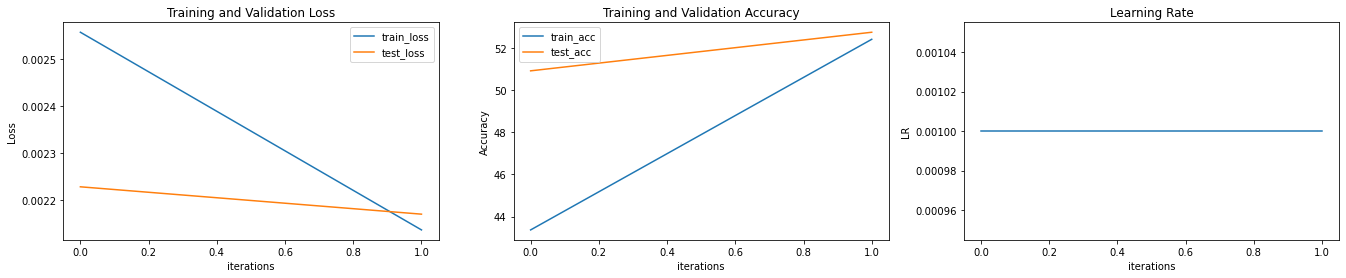

In [12]:
EPOCHS = 2
model = RegClassifier_with_dropout(p=0.4).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr': []} #dictionary for storing hitory of accuracy and losses

for epoch in range(1, EPOCHS+1):
    train_loss, train_accuracy = train(model, train_loader ,optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

위의 것을, `p=0` (no dropout)으로 바꿔서 다시 돌리게 되면, overfitting되는 것을 볼 수 있다 (test loss > train loss). 하지만, 그렇닥 p 값을 너무 키우면 accuracy가 안맞음

=> $\therefore$ at a **certain p value** overfitting이 안되면서 여전히 performance가 좋은 sweetspot을 찾을 수 있다 (모델에 따라 다르지만, 보통 p-value 0.4~0.7이 좋다고 함)

<br>

교훈 : without dropout, overfitting occurs, so **adequate p value is important**

## 1.2. Batchnorm, Dropout (again, but this time using `nn` module )

모델 정의시,
* `nn.BatchNorm2d` : expects input of (N, C, H, W) thing (like CNN output with channels
    * MLP에서 하려면 `nn.BatchNorm1d` 여야 하고, expected input type is (N, C)
    
* `nn.Dropout`: droput 하는 것 

등으로 regularziation techinques 적용 가능

<br>

Q : evaluation 할때는 batchnorm하면서 얻은 결과들 (average, std)를 써야한다고 했는데, 이것은 어떻게 하냐? => by looking at the documentaiotn on `nn.BatchNorm1d` we see below that : 
```
 |  Also by default, during training this layer keeps running estimates of its
 |  computed mean and variance, which are then used for normalization during
 |  evaluation. The running estimates are kept with a default :attr:`momentum`
 |  of 0.1.
```

**things changed from the lab video code**
* added 1d batch norm thing when doing MLP (lab video에서는 CNN 할때만 batchnorm2d를 썼다)

In [13]:
class all_regularization_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features=8), #num_features : (N, C, H, W) input에서 C (i.e. channel size)
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2)            
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 512),
            #nn.BatchNorm1d(num_features=512), #1d batchnorm도 이런식으로 하기 가능!! 다만, 이것하면 performance acutally decreases..
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.mlp(x)
        
        return x

## 1.3. early stopping, L1, L2 regularization
Early Stopping과 L1, L2 regularization은 training/testing phase에서 취한다
*  Early Stopping : training 할때, 다음 epoch의 training loss 가 improve되지 않으면 early stopping을 하도록 만들 수 있다 (밑에 코드에서 구현 되어 있음)
    * 추가적으로, `patience`같은 것을 넣어서, patientce epoch 까지했는데도 나아지지 않으면 멈추는 식으로 했다


* implementing **L1, L2 regularization** : using `weight_decay` in `optimizer` definition 
    *  즉, `optimizer`정의할때, `weight_decay` option을 넣어줄 수 있다 (lambda값을 넣어줄 수 있음)
        * `weight_decay`를 안쓰고 loss 함수자체에서 정의할 수도 있으나, 잘 안쓰임 (unless L1, L2 regularization term is complex or unconventional)


<br>

(참고로, lr_scheduler 도 쓰기는 하는데, regularization의 한 종류는 아님)



**torch 에서 L1, L2 Regularization 하는 두가지 방법**
1. 코드에서 optimizer에서 weight decay를 썼다 (weight decay : L1, L2 regularization하는 것)
    * weight_decay라고 불리는 이유 : weight를 감소하는 효과를 지니게 되니 (regularization)을 하면
2. loss함수 자체에서 regularization term을 정의해줘서 넣는 것 

<br>
사실 weight decay와 L2 loss 는 조금씩 다르다

> 많은 책과 자료에서 L2 regularization 과 weight decay는 서로 같은 것이라고 말한다. 그럼 과연 L2 regularization과 weight decay는 정말 같은 것일까? 정답은 일부는 맞고 일부는 틀리다. SGD에 대해서는 맞지만 Adam에 대해서는 틀리다. Adam을 포함한 adaptive learning rate를 사용하는 optimizer들은 SGD와 다른 weight 업데이트 식을 사용하기 때문이다. 

출처 : https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html

<br><br>
weight decay pytorch에 대한 설명 : https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105/10


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

/Users/eunmi/opt/anaconda3/envs/ML_tutor/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

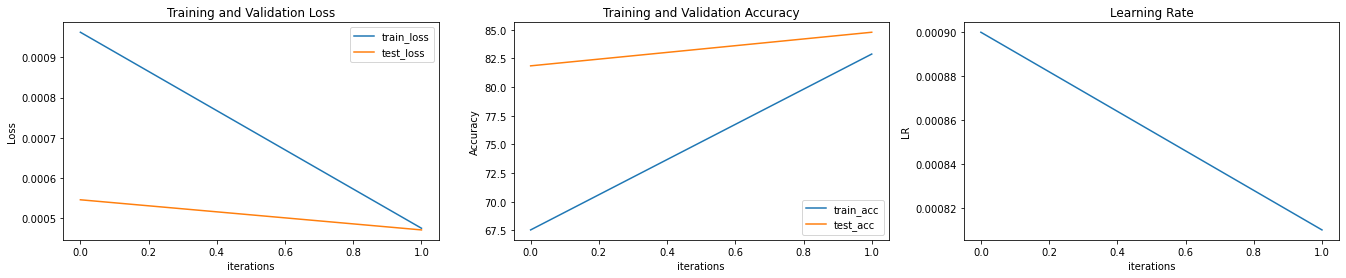

In [14]:
from torch.optim.lr_scheduler import ExponentialLR

#some hyperparameters
EPOCHS = 2
model = all_regularization_model().to(DEVICE)
criterion = nn.CrossEntropyLoss()

#tracking the history #list 가 아닌 dictionary쓰면 더 편하다
history = {'train_loss': [],'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

#implementing L1, L2 regulariza†ion : weight_decay in optimizer definition (not quite)
#implementing schedulered learning rate (not regularization though)
optimizer_L2_reg = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01) #0.01 lambda 값
scheduler_exp = ExponentialLR(optimizer, gamma = 0.9) #optimizer object를 input으로 얻는다!!


best_test_loss = 1000 #best test loss 를 initialize
patience = 2 #patience : test loss가 나아지기까지 얼마나 기다릴지 

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer = optimizer_L2_reg, scheduler = scheduler_exp)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    ###adding the loss ,acc values to the history dictionary
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr']) #getting the learing rate info
    
    ####early stopping : if test loss gets larger, stops###
    if test_loss <= best_test_loss : 
        best_test_loss = test_loss  #update best test loss
    else : 
        patience += 1 
        if patience >=2:
            break
 
plot_history(history) 

## 2. Learning Rate Decay (custom하게 learning rate decay시키는 것을 이번에 배우자)
참고로, 주의 : weight decay vs learning rate decay

* weight decay : model parameter의 decay (regularization)
* learning rate decay : learning rate자체의 decay (not regularization)

learning rate decay + ADAM : 우리그 배운 note정리한 것 보기!(정리하기)

### 2.1. CUSTOM Learning Rate Scheduler
(강의에서 설명이 많이 빈약해서 추가적인 것을 많이 적음)
 <br>

원래 우리는 `from torch.optim.lr_scheduler import ExponentialLR` 이런식으로 learning rate scheduler (in this case exponential one)을 불러와서 썼다... 그런데, **자유자재로 learning rate를 줄였다가 늘렸다가 하고 싶으면?** => **custom learning rate scheduler** 을 만들면 된다.

<br>

이, custom learning rate scheduler은 어떤 특성을 가져야할까?

1. `optimizer` instance를 wrapping하는 함수여야 한다 
    * (just as the `ExponentialLR` instance takes in `optimizer` instance as input)
    * `optimizer.param_groups[0]['lr']`값을 바꿔줌으로서, learning rate를 change하게 한다 (remember from lab2?)
2. `.step()`라는 method사용으로 learning rate update를 실행하도록 한다
    * 이렇게 하는 이유 : 이미 만들어져있는 `ExponentialLR`같은 경우도, `train()`함수에서 `.step()`을 써서 learning rate update를 하기 때문에, 우리가 만드는 class도 이런 방법으로 (`.step()`으로) update가 일어나야 한다
3. `.n_steps`같은 것으로 현재 step을 attribute로 keep-track해야한다
    * 즉, 현재 몇번째 step에 있는지 class내의 attribute로 keep-track해야한다

### 2.1.1. Custom lr scheduler하나 정의해보자
우리는, 밑의 사진처럼 Initial Warmup, then discretized/continuous exponential lr decay를 하는 custom learning rate scheduler 를 정의해보도록 하자. 이 `ScheduledOptim`은 다음과 같은 특성을 가져야함

1. 위 cell에서 언급한 특성들을 가져야함. (i.e.:)
    * `optimizer`을 input으로 받고
    * `.step()`이라는 method를 가져야 하고
    * `.n_steps`로 현재 step을 keep-track
   
2. 밑의 것들을 하기 위해서는 다음과 같은 것들이 추가적으로 필요함
    * `decay_rate`라는 것을 input으로 받아, learing rate줄일때마다 그만큼 줄이자
    * `n_warmup_steps`를 두어, 그 전까지는 linearly 하게 lr을 0 에서 `optimizer`에서 정한 `initial learning rate`까지 증가시키자
    * `step_schedule`라는 list를 input으로 받아, lr을 update하도록 하자
        * ex : `steps_schedule = [4, 10]`이면, 4번째 step까지는 keep lr, then decay_rate만큼 lr 감소시킨후, 10번째 step까지는 또다시 lr을 keep
        * if not provided, `step_schedule = None`이 되어, 모든 step에서 decay_rate 만큼 lr 이 감소하도록 한다
    * also, lets do the following to keep track and stuff
    
        following things to keep up
        * `self.n_steps` : 현재 learning rate scheduler 에서의 
        * `lr` : new lr 값 to be updated to
        * `self.current_lr` : lr of this current step
        * `self.get_lr()` : lr값을 가져오는 것
<br>


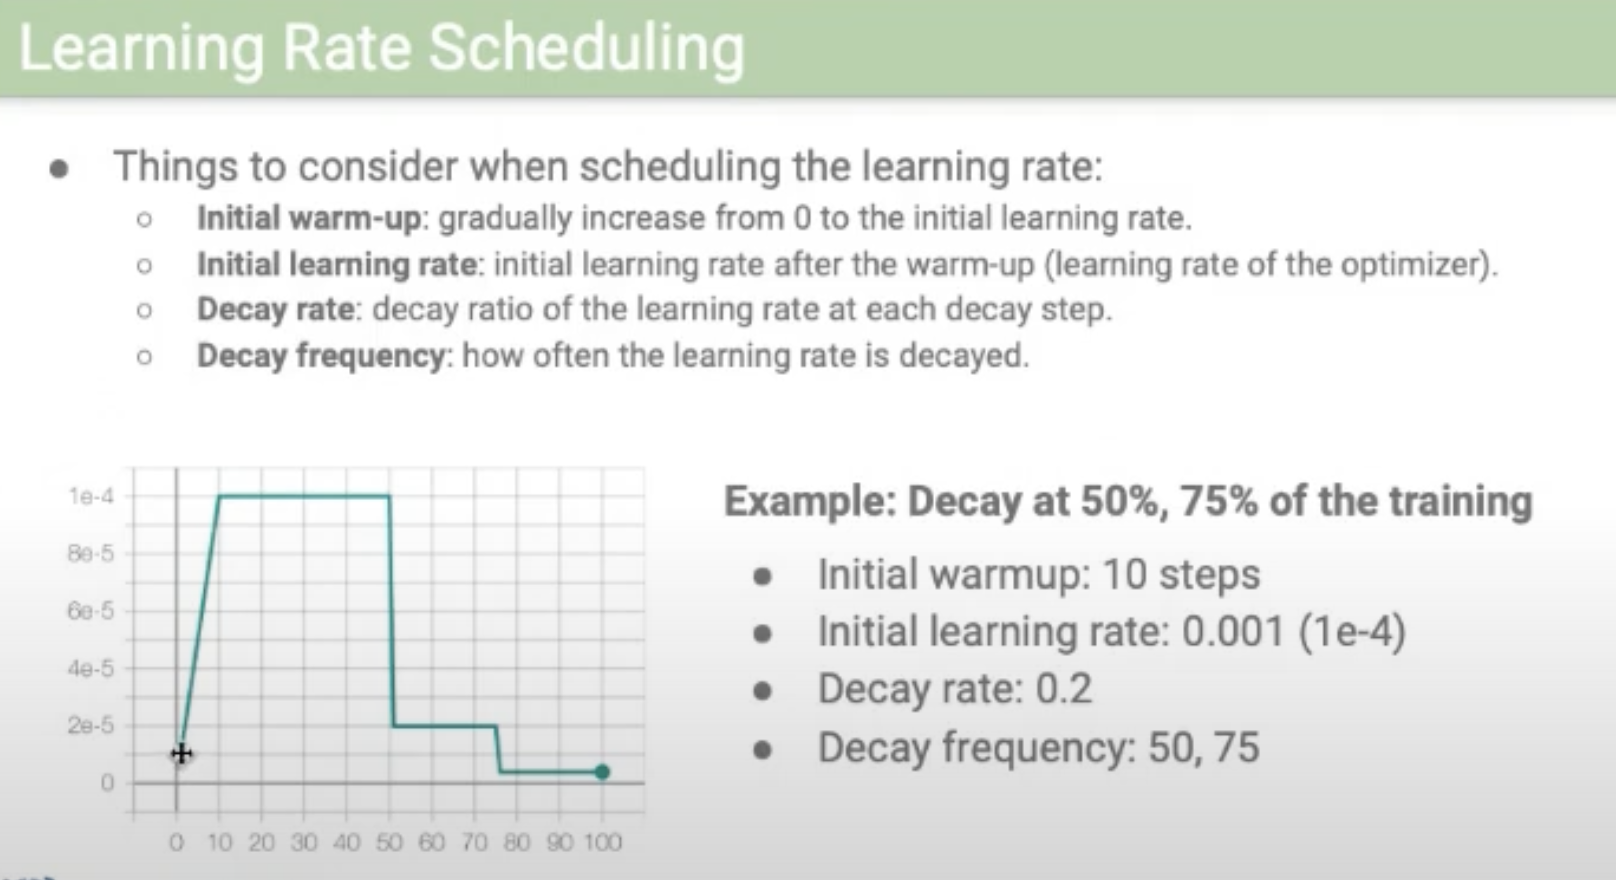


In [15]:
## Implementing CUSOTM learning rate scheduler
class ScheduledOptim():
    def __init__(self, optimizer, n_warmup_steps, decay_rate, steps_schedule = None):
        #우리가 update하게 될 optimizer을 setup해주기
        self._optimizer = optimizer 
        self.n_warmup_steps = n_warmup_steps #처음에 warmup 몇번 할지
        self.decay_rate = decay_rate
        
        #increasing/raising steps
        self.n_steps = 0          #이 값이 1씩 커질 것 
        
        self.steps_schedule = steps_schedule
        self.initial_lr = optimizer.param_groups[0]['lr'] #optimizer에서 initial learning rate가져오기
        self.current_lr = None #실제로 optimizer에서 사용하게 될  learning rate
    
    def zero_grad(self):
        self._optimizer.zero_grad() #optimizer 을 zero-grad로 두기 #batch마다 grad zero로서 다시 시작해야하기에 이렇게 함
    
    def get_lr(self):
        return self.current_lr
        
    def step(self):  #scheduler.step()를 쓰니
        #i.e. before and including warmup step
        if self.n_steps <= self.n_warmup_steps :  
            lr = self.n_steps/self.n_warmup_steps * self.initial_lr #즉, linearly learning rate증가 
            
        #i.e. after warmup step
        #lr : new lr we will put into `optimizer`
        else : 
            if self.steps_schedule == None:  ##i.e. list의 형태로 steps schedule이 지정되지 않으면, default로 모든 step마다 exponential decay하기
                lr = self.current_lr * self.decay_rate
            else: 
                if self.n_steps in self.steps_schedule:
                    lr = self.current_lr*self.decay_rate
                else:
                    lr = self.current_lr
            
        self.current_lr = lr #UPDATE lr
        
        self._optimizer.param_groups[0]['lr'] = lr
        
        self.n_steps += 1 #increase current number of states

                

Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.00000, 	Train Loss: 0.0023, 	Train Accuracy: 9.82 %, 	Test Loss: 0.0023, 	Test Accuracy: 9.89 % 



Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.00050, 	Train Loss: 0.0007, 	Train Accuracy: 73.55 %, 	Test Loss: 0.0005, 	Test Accuracy: 83.71 % 



Epoch 3:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.00100, 	Train Loss: 0.0004, 	Train Accuracy: 85.00 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.14 % 



Epoch 4:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.00100, 	Train Loss: 0.0003, 	Train Accuracy: 87.19 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.72 % 



Epoch 5:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.00080, 	Train Loss: 0.0003, 	Train Accuracy: 88.53 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.42 % 



Epoch 6:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.00080, 	Train Loss: 0.0003, 	Train Accuracy: 89.40 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.36 % 



Epoch 7:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.00080, 	Train Loss: 0.0003, 	Train Accuracy: 89.91 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.49 % 



Epoch 8:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.00064, 	Train Loss: 0.0003, 	Train Accuracy: 90.44 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.67 % 



Epoch 9:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.00064, 	Train Loss: 0.0002, 	Train Accuracy: 90.86 %, 	Test Loss: 0.0003, 	Test Accuracy: 90.20 % 



Epoch 10:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.00064, 	Train Loss: 0.0002, 	Train Accuracy: 91.13 %, 	Test Loss: 0.0003, 	Test Accuracy: 90.41 % 



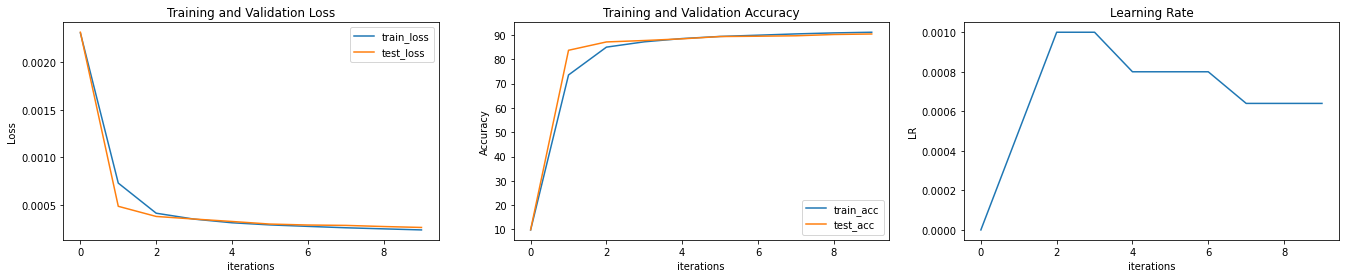

In [23]:
## applying customized learning rate scheduler
EPOCHS = 10
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

model = all_regularization_model().to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#defining the customized scheduler thing
steps_schedule = [4,7,10,15]
scheduler = ScheduledOptim(optimizer, n_warmup_steps = 2, decay_rate=0.8, steps_schedule = steps_schedule)
patience = 2 #patience : 위에서 implement다시하기!
best_loss = 100
scheduler.step() 
    #이것을 해주는 이유 : 이것을 안쓰면, learning rate를 optimizer 정의할때 한 initial learning rate를 쓸탠데,
    #우리는 warm start up을 할것이기 때문에, lr=0에서시작해야함.
    #따라서, .step()을, epoch들어가기 전에 해줘야함!

for epoch in range(1, EPOCHS + 1):
    lr = scheduler.get_lr()       #get_lr
    train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tLR: {:.5f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, lr, train_loss, train_accuracy, test_loss, test_accuracy))
    
    #Early stopping with patience
    if test_loss < best_loss :
        best_loss = test_loss
    else:
        patience += 1 
        if patience >=2:
            break
    ##############

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(lr)
    
plot_history(history)

## Supplementary : questions and answers

### S.1 : `nn.CrossEntropyLoss`와 `F.log_softmax`를 같이 쓰면 안되는 이유 

* 즉 `nn.CrossEntropyLoss`를 training할때 `criterion`으로 정의를 했는데, `nn.CrossEntropyLoss`는 내부적으로 softmax => log loss이다 (http://www.gisdeveloper.co.kr/?p=8668). 즉, softmax는 output값들을 각 class일 확률로 바꿔주고, 이 확률 값들을 log loss에 넣어서 cross entropy loss를 구한는 것
* 따라서, lab3강의에서 했던 것처럼 model내에서 softmax를 행한 후, 다시 `nn.CrossEntropyLoss`를 실행하게 되면, softmax를 두번 실행하게 됨으로 하면 안됨

* 따라서 `nn.CrossEntropyLoss`는 input이 raw여야지, logit (i.e. 0~1사이로 scaling된 값)이 들어가면 안됨
    * (이유에 대한 similar problem에 대한 설명 : https://discuss.pytorch.org/t/noob-question-model-doesnt-update/156626) (그래서 commented out)
* 제대로 이해하고 싶으면 Ian Goodfellow Deep Learning책을 보기



### S.2 : `.view`, `.flatten` 등의 차이 => **.flatten**은 batch dimension을 유지하지 않기 때문에 에러가 된다!

#### S.2.1. 먼저, `.view`에 대한 공부

In [17]:
x = torch.randn(4,4)
print(x.shape)                 #(4,4)
print(x.view(16).shape)        #(16)
print(x.view(-1,8).shape)      #(2,8)
print(x.view(2,2,2,2).shape)   #(2,2,2,2)
print(x.view(2,-1,2,2).shape)  #(2,2,2,2)  #i.e,. infers automatically (if possible)

torch.Size([4, 4])
torch.Size([16])
torch.Size([2, 8])
torch.Size([2, 2, 2, 2])
torch.Size([2, 2, 2, 2])


#### S.2.2. `.view`와 `.flatten()`의 차이 

In [18]:
#실제 우리 input 의 경우에는 어떻게 view가 reshaping 이 될까?
a, b = next(iter(train_loader))
print(a.shape)                   #(1024, 1, 28, 28)
print(a.view(1024,-1).shape)     #(1024, 28*28) #즉, 1024 batch size는 유지하고 나머지는 flatten
print(a.view(a.shape[0],-1).shape)


####COMPARE FOR : JUST FLATTEN 
print(a.flatten().shape)         #(802816)

torch.Size([1024, 1, 28, 28])
torch.Size([1024, 784])
torch.Size([1024, 784])
torch.Size([802816])


따라서, model내에서 돌아갈때 (batchsize, X, X)로 input shape가 유지되어야 하기에, `a.flatten`으로 `def forward`에서 쓰면 안됨!! (because it doesn't preserve the batch dimensions) (batch가 없더라도, batchsize=1로 유지해줘야함)
* 즉, `nn`이라는 것은 `batch dimension`이 있는 input 을 가정하고 만든것!

### S.3 참고로, kernel restart errore등등이 나면 => collabe돌려보고 문제를 찾기 

다음부터 kernel restart error있으면 collab에 돌려보고 문제를 찾기! (collab이 환경이 제일 잘 되어있음)